In [73]:
import pandas as pd
from datetime import date, datetime, timedelta
import pickle
import numpy as np
from math import sqrt
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import math

<h3> The below lines of code are an adaptation of the code in the GUI used to determine hotspots <h3>

In [74]:
NUM_HOTSPOTS = 10

In [75]:
def open_file():
    try:
        DATA_FILE = pd.read_csv(DEFAULT_FILE_PATH+ CSV_FILE_EXTENSION)
    except:
        print("File not found")
    return DATA_FILE

In [76]:
# Define file variables
DEFAULT_FILE_PATH = "CrimeGUI/data"
CSV_FILE_EXTENSION = ".csv"
DATA_FILE = pd.DataFrame()
FILTERED_DATA = pd.DataFrame()
DATA_FILE = open_file()
FIRST_DATE = datetime.strptime(DATA_FILE['Date'].iloc[0], '%d/%m/%Y')
LAST_DATE = datetime.strptime(DATA_FILE['Date'].iloc[len(DATA_FILE) - 1], '%d/%m/%Y')
MODEL_FEATURE_SEPARATOR = "_"
MODEL_PATH = "CrimeGUI/Models/"
COMMA_SPACE = ", "
INCIDENT_COL_KEY = "Todays Reports"
NEIGHBOURHOOD_COL_KEY = "Neighborhood"
DATE_COL_KEY = "Date"

In [77]:
# Define feature selection variables
F_REGRESSION_NAME = "F-Regression"
F_REGRESSION_FILE_TAG = "f_regression"
CHI2_NAME = "Chi-Squared"
CHI2_FILE_TAG = "chi2"
ADABOOST_NAME = "AdaBoost"
ADABOOST_FILE_TAG = "adaboost"
EQUAL_DATA_NAME = "Equal Selection"
EQUAL_DATA_FILE_TAG = "equal_crime_and_business"
ALL_BUS_NAME = "All Business"
ALL_BUS_FILE_TAG = "all_business"
FEATURE_SELECTION = [F_REGRESSION_NAME, CHI2_NAME, ADABOOST_NAME, EQUAL_DATA_NAME, ALL_BUS_NAME]
FEATURES = {
    F_REGRESSION_NAME : ['Reports 1 day ago', 'Reports 2 days ago', 'Reports 3 days ago',
                       'Reports 4 days ago', 'Reports 5 days ago', 'Reports 6 days ago',
                      'Reports 7 days ago','Reports 14 days ago','Reports 30 days ago','Reports 365 days ago'],
    CHI2_NAME : ['South of Market', 'Mission', 'Tenderloin', 'Number of businesses', 
               'Downtown / Union Square', 'Civic Center', 'Reports 365 days ago',
               'Reports 1 day ago','Reports 2 days ago','Reports 14 days ago'],
    ADABOOST_NAME : ['Reports 365 days ago', 'Reports 1 day ago', 'Reports 14 days ago', 'Reports 3 days ago', 
               'Reports 2 days ago', 'Reports 7 days ago', 'Number of businesses',
               'Reports 4 days ago','Reports 5 days ago','Closures 365 days ago'],
    EQUAL_DATA_NAME : ['Number of businesses', 'Last 28 days closures', 'Last 7 days openings',
                          'Last 14 days closures', 'Last 7 days closures','Reports 1 day ago',
                      'Reports 2 days ago', 'Reports 4 days ago', 'Reports 30 days ago', 'Reports 7 days ago'],
    ALL_BUS_NAME : ['Number of businesses', 'Last 28 days closures', 'Last 7 days openings',
                          'Last 14 days closures', 'Last 7 days closures','Number of openings',
                   'Openings 4 days ago','Openings 1 day ago', 'Openings 7 days ago', 'Openings 2 days ago']
    }
FEATURE_FILE_TAGS = {
    F_REGRESSION_NAME : F_REGRESSION_FILE_TAG,
    CHI2_NAME : CHI2_FILE_TAG,
    ADABOOST_NAME : ADABOOST_FILE_TAG,
    EQUAL_DATA_NAME : EQUAL_DATA_FILE_TAG,
    ALL_BUS_NAME : ALL_BUS_FILE_TAG
    }
FEATURE_NAMES_BY_FILE_TAG = {
    F_REGRESSION_FILE_TAG : F_REGRESSION_NAME,
    CHI2_FILE_TAG : CHI2_NAME,
    ADABOOST_FILE_TAG : ADABOOST_NAME,
    EQUAL_DATA_FILE_TAG : EQUAL_DATA_NAME,
    ALL_BUS_FILE_TAG : ALL_BUS_NAME
}

In [78]:
# Define model variables
DECISION_TREE_NAME = "Decision Tree"
DECISION_TREE_FILE_TAG = "decision_tree"
ELASTIC_NET_NAME = "Elastic Net"
ELASTIC_NET_FILE_TAG = "elastic_net"
LASSO_NAME = "Lasso"
LASSO_FILE_TAG = "lasso"
LINERAR_REGRESSION_NAME = "Linear \nRegression"
LINERAR_REGRESSION_FILE_TAG = "linear_regression"
RANDOM_FOREST_NAME = "Random \nForest"
RANDOM_FOREST_FILE_TAG = "random_forest"
RIDGE_REGRESSION_NAME = "Ridge \nRegression"
RIDGE_REGRESSION_FILE_TAG = "ridge_regression"
SVM_NAME = "SVM"
SVM_FILE_TAG = "svm"
MODELS = [DECISION_TREE_NAME,
          ELASTIC_NET_NAME,
          LASSO_NAME,
          LINERAR_REGRESSION_NAME,
          RANDOM_FOREST_NAME,
          RIDGE_REGRESSION_NAME,
          SVM_NAME]
MODEL_FILE_TAGS = {
    DECISION_TREE_NAME : DECISION_TREE_FILE_TAG,
    ELASTIC_NET_NAME : ELASTIC_NET_FILE_TAG,
    LASSO_NAME : LASSO_FILE_TAG,
    LINERAR_REGRESSION_NAME: LINERAR_REGRESSION_FILE_TAG,
    RANDOM_FOREST_NAME: RANDOM_FOREST_FILE_TAG,
    RIDGE_REGRESSION_NAME: RIDGE_REGRESSION_FILE_TAG,
    SVM_NAME : SVM_FILE_TAG
    }
MODEL_NAMES_BY_FILE_TAG = {
    DECISION_TREE_FILE_TAG : DECISION_TREE_NAME,
    ELASTIC_NET_FILE_TAG : ELASTIC_NET_NAME,
    LASSO_FILE_TAG : LASSO_NAME,
    LINERAR_REGRESSION_FILE_TAG : LINERAR_REGRESSION_NAME,
    RANDOM_FOREST_FILE_TAG: RANDOM_FOREST_NAME,
    RIDGE_REGRESSION_FILE_TAG : RIDGE_REGRESSION_NAME,
    SVM_FILE_TAG : SVM_NAME
}

In [79]:
PARENT_NEIGHBOURHOODS = {
    "Central Waterfront" : ["Dogpatch"],
    "Eureka Valley" : ["Dolores Heights","Castro"],
    "Buena Vista" : ["Ashbury Heights"],
    "Cole Valley" : ["Parnassus Heights"],
    "Bayview" : ["Apparel City", "Produce Market"],
    "Russian Hill" : ["Aquatic Park / Ft. Mason"],
    "North Beach" : ["Bret Harte"],
    "Western Addition" : ["Cathedral Hill", "Japantown"],
    "Downtown / Union Square" : ["Fairmount", "Chinatown", "Lower Nob Hill", "Polk Gulch"],
    "Mission Terrace" : ["Cayuga"],
    "Northern Waterfront" : ["Fishermans Wharf"],
    "Bernal Heights" : ["Holly Park", "Peralta Heights", "St. Marys Park"],
    "Hunters Point" : ["India Basin"],
    "Forest Hill" : ["Laguna Honda"],
    "Hayes Valley" : ["Lower Haight"],
    "Portola" : ["McLaren Park", "University Mound"],
    "South of Market" : ["Mint Hill"],
    "Stonestown" : ["Parkmerced"],
    "Presidio Heights" : ["Presidio Terrace"],
    "South Beach" : ["Rincon Hill"],
    "Potrero Hill" : ["Showplace Square"],
    "Visitacion Valley" : ["Sunnydale"],
    "Lincoln Park / Ft. Miley" : ["Sutro Heights"],
    "Cow Hollow" : ["Union Street"]
    }

In [80]:
def get_hotspots(data, model_key, features_key,calendar_date):
    x_data = data.loc[data[DATE_COL_KEY].str.contains(calendar_date)]
    neighbourhoods_data = pd.DataFrame(x_data[NEIGHBOURHOOD_COL_KEY])
    neighbourhoods_data.reset_index(drop=True, inplace=True)
    y_data = pd.DataFrame(x_data[INCIDENT_COL_KEY])
    y_data.reset_index(drop=True, inplace=True)
    features_selected = FEATURES[features_key]
    x_data = x_data[features_selected]
    return load_model(x_data, y_data, neighbourhoods_data, model_key, features_key)

In [81]:
def load_model(x_data, y_data, neighbourhoods_data, model_key, features_key):
    model_tag = MODEL_FILE_TAGS[model_key]
    feature_tag = FEATURE_FILE_TAGS[features_key]
    file_path = MODEL_PATH + model_tag + MODEL_FEATURE_SEPARATOR + feature_tag
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
        return make_prediction(model, x_data, y_data, neighbourhoods_data)

In [82]:
def make_prediction(model, x_data, y_data, neighbourhoods_data):
    y_predict = model.predict(x_data)
    y_actual,y_predict,neighbourhoods_data = merge_sub_neighbourhoods(y_data,y_predict,neighbourhoods_data)
    total_predictions = len(y_predict)
    neighbourhoods_data.reset_index(drop=True, inplace=True)
    prediction_neighbourhoods = neighbourhoods_data[NEIGHBOURHOOD_COL_KEY].to_numpy()
    actual_neighbourhoods = prediction_neighbourhoods.copy()
    indexes = y_actual.argsort()
    y_actual = np.flip(y_actual[indexes])
    actual_neighbourhoods = np.flip(actual_neighbourhoods[indexes])
    indexes = y_predict.argsort()
    y_predict = np.flip(y_predict[indexes])
    prediction_neighbourhoods = np.flip(prediction_neighbourhoods[indexes])
    return y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods

In [83]:
def get_non_negative_value(value):
    if value < 0:
        return 0
    else:
        return value

In [84]:
def merge_sub_neighbourhoods(y_data,y_predict,neighbourhoods_data):
    y_data = pd.DataFrame(y_data).to_numpy().flatten()
    indexes_to_remove = []
    for parent_key in PARENT_NEIGHBOURHOODS:
        parent_index = neighbourhoods_data.index[neighbourhoods_data[NEIGHBOURHOOD_COL_KEY] == parent_key].tolist()[0]
        y_predict_parent_value = get_non_negative_value(y_predict[parent_index])
        y_data_parent_value = get_non_negative_value(y_data[parent_index])
        for sub_neighbourhood in PARENT_NEIGHBOURHOODS[parent_key]:
            sub_neighbourhood_index = neighbourhoods_data.index[neighbourhoods_data[NEIGHBOURHOOD_COL_KEY] == sub_neighbourhood].tolist()[0]
            indexes_to_remove.append(sub_neighbourhood_index)
            y_predict_sub_neighbourhood_value = get_non_negative_value(y_predict[sub_neighbourhood_index])
            y_predict_parent_value = y_predict_parent_value + y_predict_sub_neighbourhood_value
            y_data_sub_neighbourhood_value = get_non_negative_value(y_data[sub_neighbourhood_index])
            y_data_parent_value = y_data_parent_value + y_data_sub_neighbourhood_value
        y_predict[parent_index] = y_predict_parent_value
        y_data[parent_index] = y_data_parent_value
    neighbourhoods_data = neighbourhoods_data.drop(neighbourhoods_data.index[indexes_to_remove])
    indexes_to_remove.sort(reverse=True)
    for index in indexes_to_remove:
        y_predict = np.delete(y_predict,index)
        y_data = np.delete(y_data,index)
    return y_data,y_predict,neighbourhoods_data 

<h3>GUI code ends here<h3>
<h3>Evaluation code follows<h3>

In [85]:
def calculate_accuracy(y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods):
    total_predictions = len(y_predict)
    predicted_hotspots, actual_hotspots = determine_hotspots(y_actual, 
                                                             actual_neighbourhoods, 
                                                             prediction_neighbourhoods)
    num_predictions = len(predicted_hotspots)
    classification_scores = calculate_standard_scores(num_predictions,
                                                      predicted_hotspots,
                                                      actual_hotspots,
                                                      total_predictions)
    misclassification_scores = get_missed_incidents(predicted_hotspots, 
                                                    actual_hotspots, 
                                                    y_actual, 
                                                    y_predict,
                                                    num_predictions,
                                                    actual_neighbourhoods)
    return classification_scores + misclassification_scores

In [86]:
def get_missed_incidents(predicted_hotspots, actual_hotspots, y_actual, y_predict,num_predictions,actual_neighbourhoods):
    incidents_correct = 0
    incidents_missed = 0
    additional_incidents_caught = 0
    for neighbourhood in predicted_hotspots:
        index = np.where(actual_neighbourhoods == neighbourhood)[0]
        value = y_actual[index]
        if neighbourhood in actual_hotspots:
            incidents_correct += value
        else:
            additional_incidents_caught += value
    i = 0
    i_limit = 0
    lowest_actual = y_actual[num_predictions-1]
    while i < num_predictions:
        if y_actual[i] != lowest_actual:
            neighbourhood = actual_hotspots[i]
            if neighbourhood not in predicted_hotspots:
                index = np.where(actual_neighbourhoods == neighbourhood)[0]
                value = y_actual[index]
                incidents_missed += value
            i += 1
        else:
            i_limit = i
            i = num_predictions
    i = i_limit
    remaining_hotspots_to_find = num_predictions - i
    hotspots_found = 0
    while i < len(actual_hotspots):
        neighbourhood = actual_hotspots[i]
        if neighbourhood in predicted_hotspots:
            hotspots_found += 1
        i += 1
    num_lowest_value_hotspots_missing = remaining_hotspots_to_find - hotspots_found
    lowest_values_missed = lowest_actual * num_lowest_value_hotspots_missing
    incidents_missed += lowest_values_missed
    total_actual_hotspots = incidents_correct + incidents_missed
    net_missed = incidents_missed - additional_incidents_caught
    misclassification_severity = net_missed / total_actual_hotspots
    return [misclassification_severity]

In [87]:
def determine_hotspots(y_actual, actual_neighbourhoods, prediction_neighbourhoods):
    predicted_hotspots = prediction_neighbourhoods[:NUM_HOTSPOTS]
    actual_hotspots = actual_neighbourhoods[:NUM_HOTSPOTS]
    lowest_hotspot_value = y_actual[NUM_HOTSPOTS-1]
    i = NUM_HOTSPOTS
    while i < len(actual_neighbourhoods):
        if y_actual[i] == lowest_hotspot_value:
            np.append(actual_hotspots,actual_neighbourhoods[i])
            i += 1
        else:
            i = len(actual_neighbourhoods)
    return predicted_hotspots, actual_hotspots

In [88]:
def calculate_standard_scores(num_predictions,predicted_hotspots,actual_hotspots,total_predictions):
    #true positives
    tp = 0
    #false positives
    fp = 0
    for i in range(num_predictions):
        if predicted_hotspots[i] in actual_hotspots:
            tp += 1
        else:
            fp +=1
    #true negatives
    tn = total_predictions-num_predictions-fp
    #false negatives
    fn = fp
    #sensitivity/recall
    sensitivity = 0
    if tp + fn != 0:
        sensitivity = tp / (tp + fn)
    #specificity
    specificity = 0
    if tn + fp !=0:
        specificity = tn / (tn + fp)
    #precision
    precision = 0
    if tp + fp !=0:
        precision = tp / (tp + fp)
    #f1 - incorporates both sensitivity/recall and precision
    f1 = 0
    if precision + sensitivity != 0:
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    #matthews correlation coefficient
    mcc = 0
    if sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn+fn)) != 0:
        mcc = ((tp * tn) - (fp * fn)) / (sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn+fn)))
    return [sensitivity, specificity, precision, f1, mcc]

In [89]:
def get_results():
    all_scores = {}
    for score_key in SCORE_KEYS:
        all_scores[score_key] = []
    algorithm_names = []
    for model_key in MODELS:
        for feature_key in FEATURES:
            scores = score_algorithm(model_key, feature_key)
            for score_key in SCORE_KEYS:
                all_scores[score_key].append(scores[score_key])
            algorithm_names.append(model_key + "\n" + feature_key)
    return all_scores, algorithm_names

In [90]:
def score_algorithm(model_key, feature_key):
    start_date = FIRST_DATE
    all_scores = {}
    for score_key in SCORE_KEYS:
        all_scores[score_key] = []
    while start_date <= LAST_DATE:
        y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods = get_hotspots(DATA_FILE, 
                                                                                model_key, 
                                                                                feature_key, 
                                                                                str(start_date.strftime("%d/%m/%Y")))
        results = calculate_accuracy(y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods)
        for i in range(len(SCORE_KEYS)):
            all_scores[SCORE_KEYS[i]].append(results[i])
        start_date += timedelta(days=1)
    averages = {}
    for score_key in SCORE_KEYS:
        averages[score_key] = sum(all_scores[score_key]) / len (all_scores[score_key])
    return averages

In [91]:
def best_x_scores(score_metric,x,algorithms,results):
    all_labels = algorithms.copy()
    x_labels = []
    best_scores = []
    scores = results[score_metric].copy()
    num_scores = len(scores)
    x = validate_x(num_scores,x)
    i = 0
    while i < x:
        if HIGHEST_IS_BEST[score_metric]:
            index = np.argmax(scores)
        else:
            index = np.argmin(scores)
        x_labels.append(all_labels[index])
        best_scores.append(scores[index])
        all_labels = np.delete(all_labels,index)
        scores = np.delete(scores,index)
        i+=1
    y_select = np.arange(len(best_scores))
    plt.figure(figsize = (15,15))
    plt.xticks(y_select,x_labels)
    #plt.xticks(rotation=45)
    plt.title("Top " + str(x) + " " + score_metric + " scores\nwhen predicting the top " 
              + str(NUM_HOTSPOTS) + " Crime Hotspots")
    plt.xlabel("Algorithm")
    plt.ylabel(score_metric + " score")
    high_score = max(best_scores)
    low_score = min(best_scores)
    min_y = low_score - 0.5 * (high_score - low_score)
    max_y = high_score + 0.5 * (high_score - low_score)
    plt.ylim(bottom = min_y, top = max_y)
    bar = plt.bar(y_select, best_scores)
    return bar

In [92]:
def get_labels():
    labels = []
    for algorithm in algorithms:
        for sel_method in sel_methods:
            labels.append(algorithm_display_names[algorithms.index(algorithm)] + "\nusing\n" + 
                          feature_select_display_names[np.nonzero(sel_methods == sel_method)[0][0]] + "\ndataset")
    return labels

In [93]:
def validate_x(num_scores,x):
    soft_cap = 15
    if x > num_scores or x < 1:
        if num_scores > soft_cap:
            return soft_cap
        else:
            return num_scores
    return x

In [94]:
SENSITIVITY_KEY = "Sensitivity"
SPECIFICITY_KEY = "Specificity"
PRECISION_KEY = "Precision"
F1_KEY = "F1"
MCC_KEY = "MCC"
SEVERITY_KEY = "Lowest Misclassification Severity"
SCORE_KEYS = [
    SENSITIVITY_KEY,
    SPECIFICITY_KEY,
    PRECISION_KEY,
    F1_KEY,
    MCC_KEY,
    SEVERITY_KEY
]
HIGHEST_IS_BEST = {
    SENSITIVITY_KEY: True,
    SPECIFICITY_KEY: True,
    PRECISION_KEY: True,
    F1_KEY:True,
    MCC_KEY: True,
    SEVERITY_KEY: False
}

NUM_HOTSPOTS_RANGE = [5,10,15,20]

In [95]:
def evaluate_models():
    bars = []
    for i in NUM_HOTSPOTS_RANGE:
        NUM_HOTSPOTS = i
        results, algorithms = get_results()
        for metric in SCORE_KEYS:
            top_x = 10
            bars.append(best_x_scores(metric,top_x,algorithms,results))
    return bars

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray fr

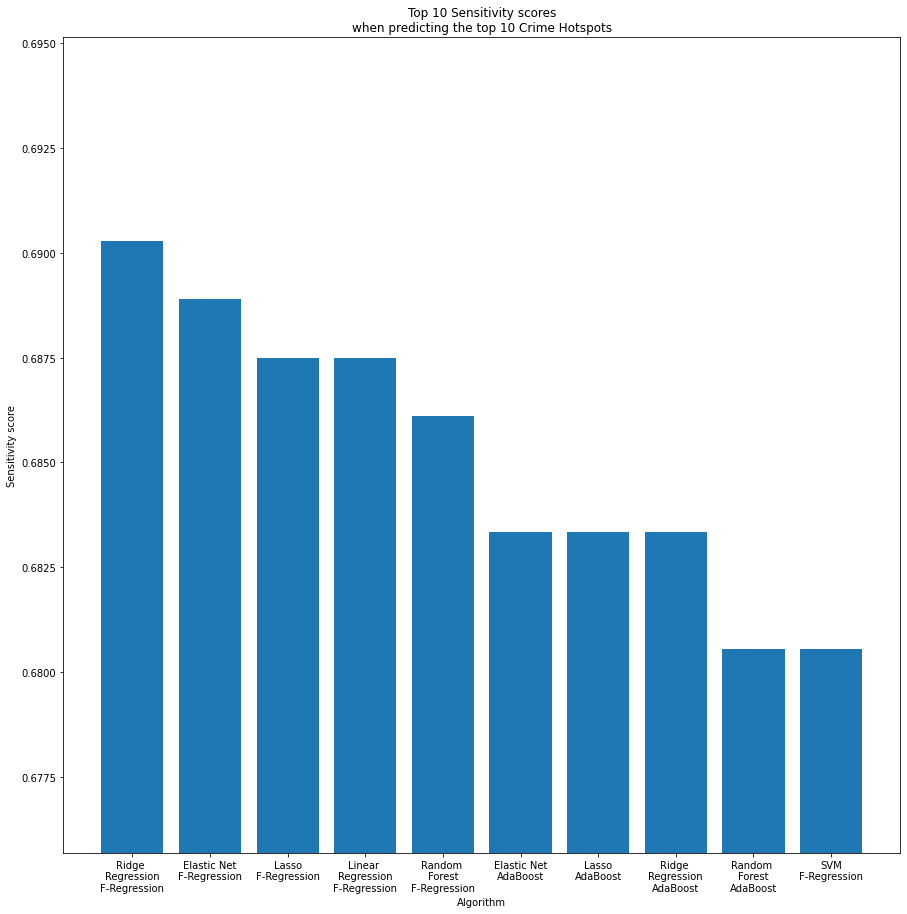

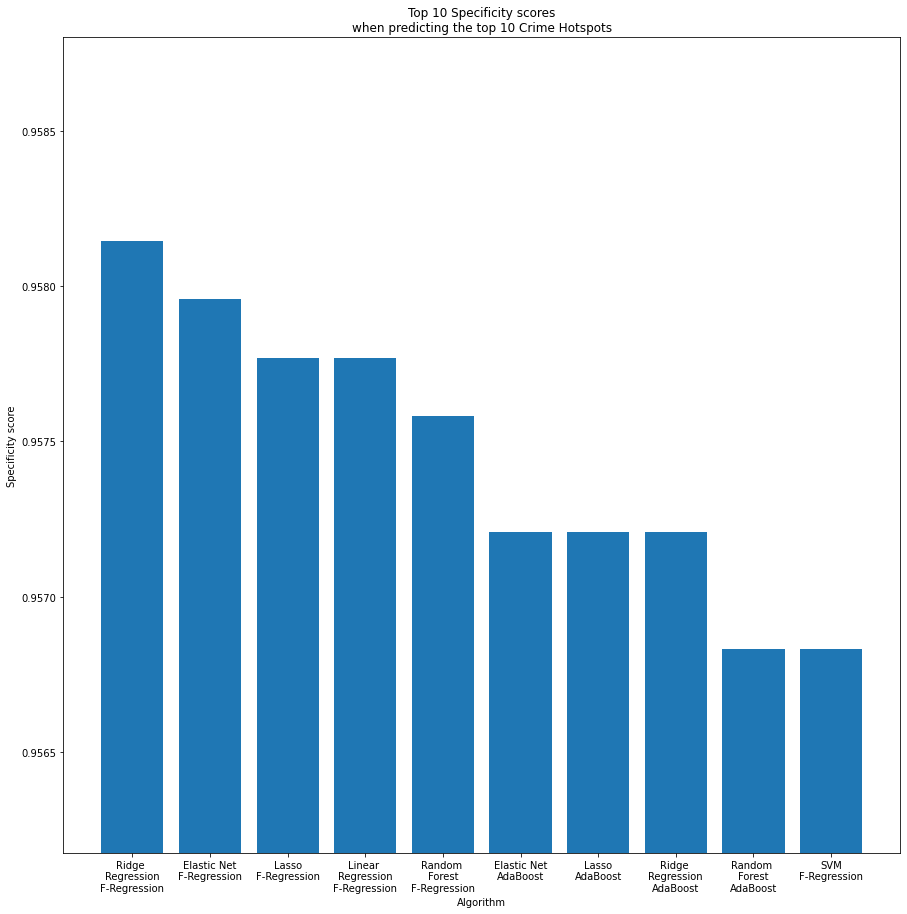

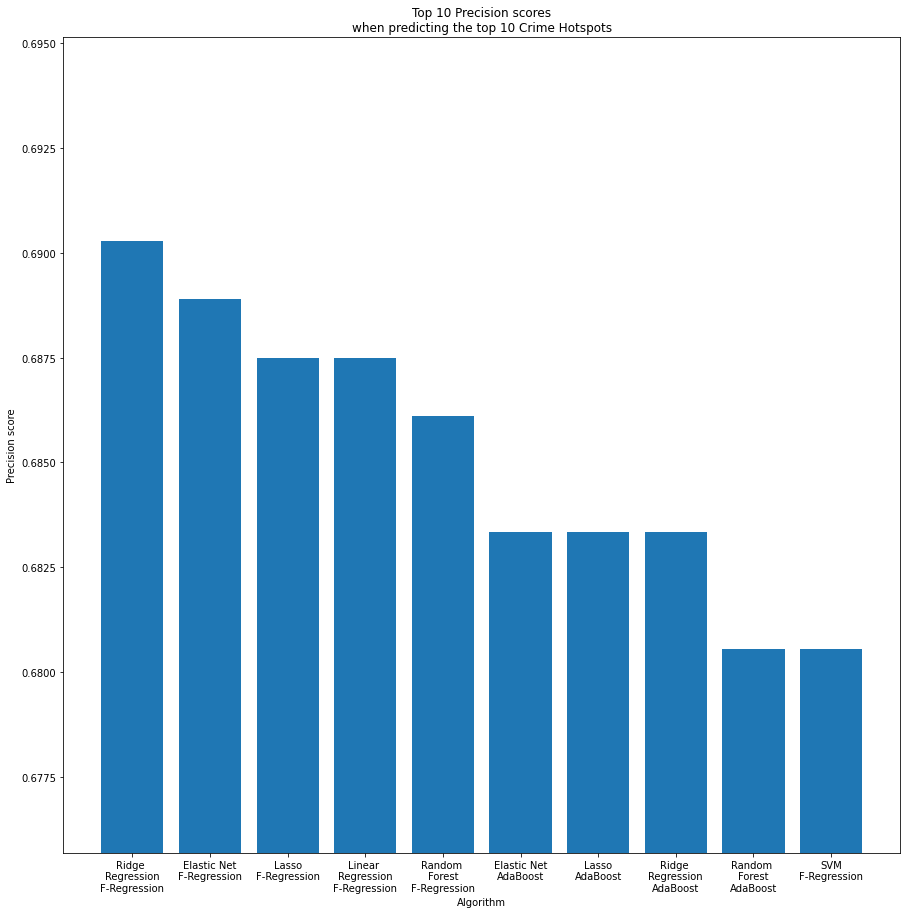

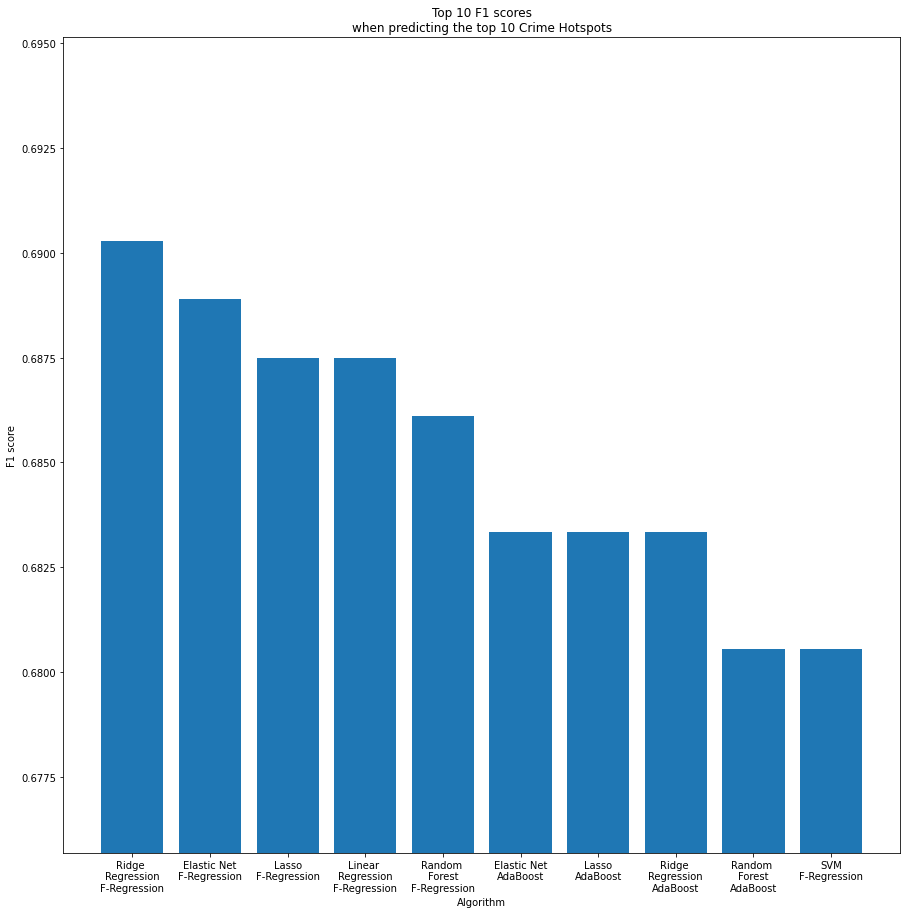

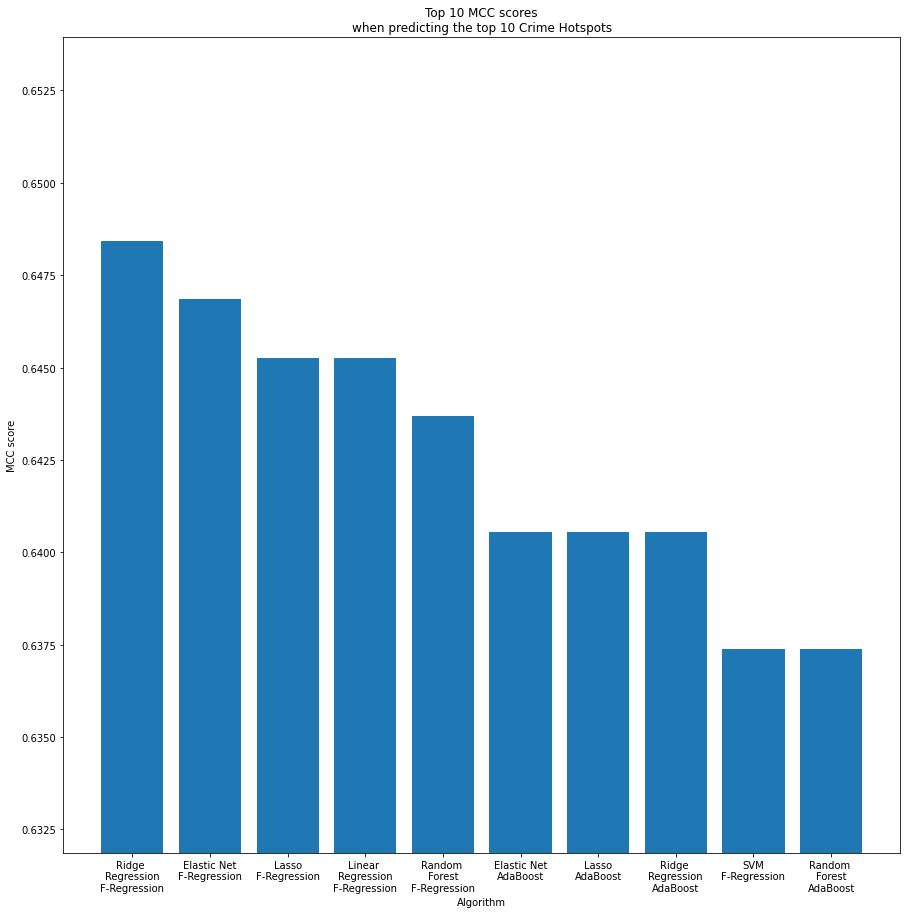

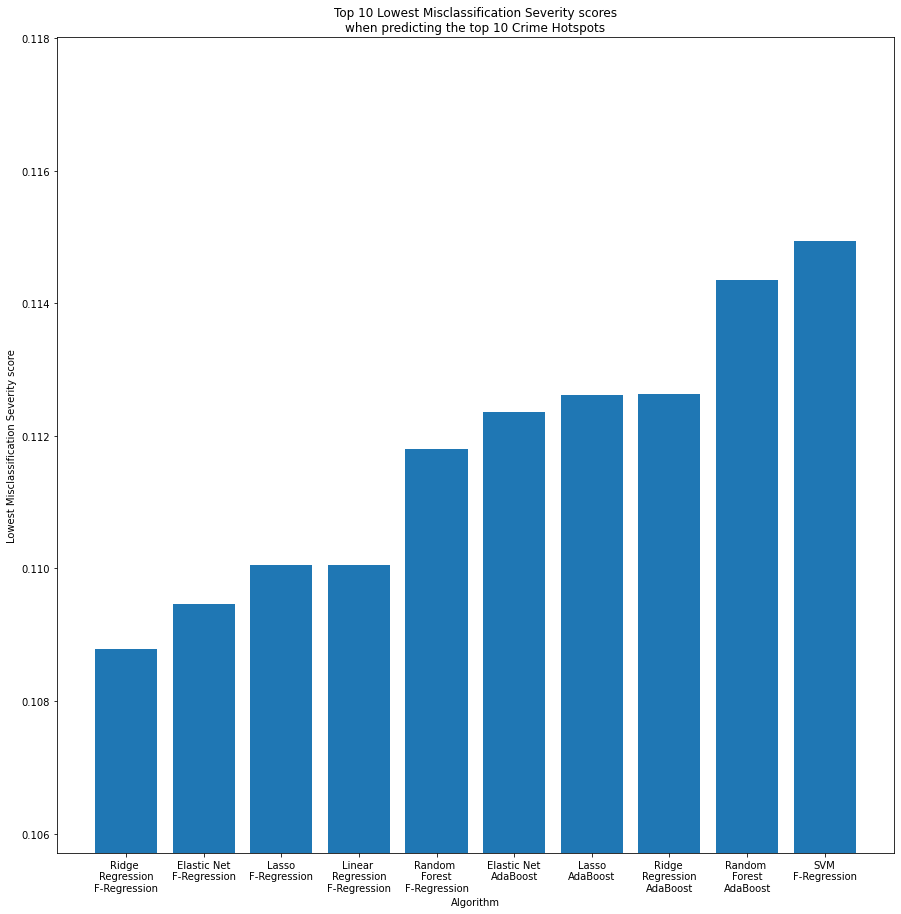

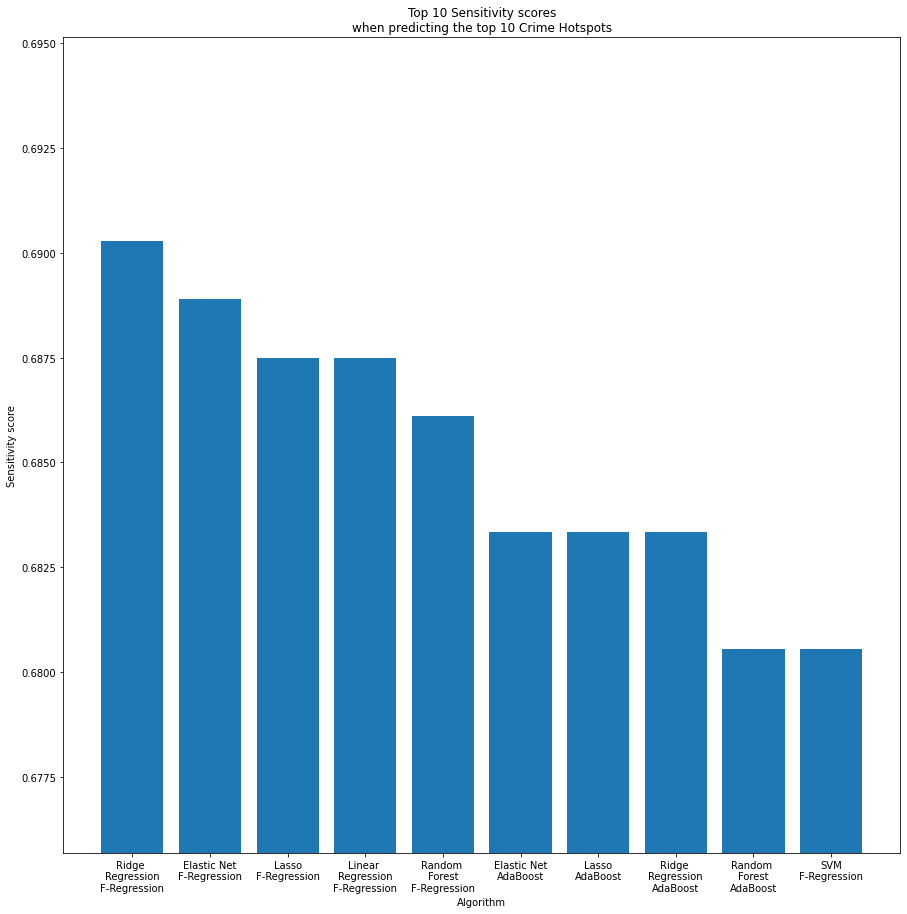

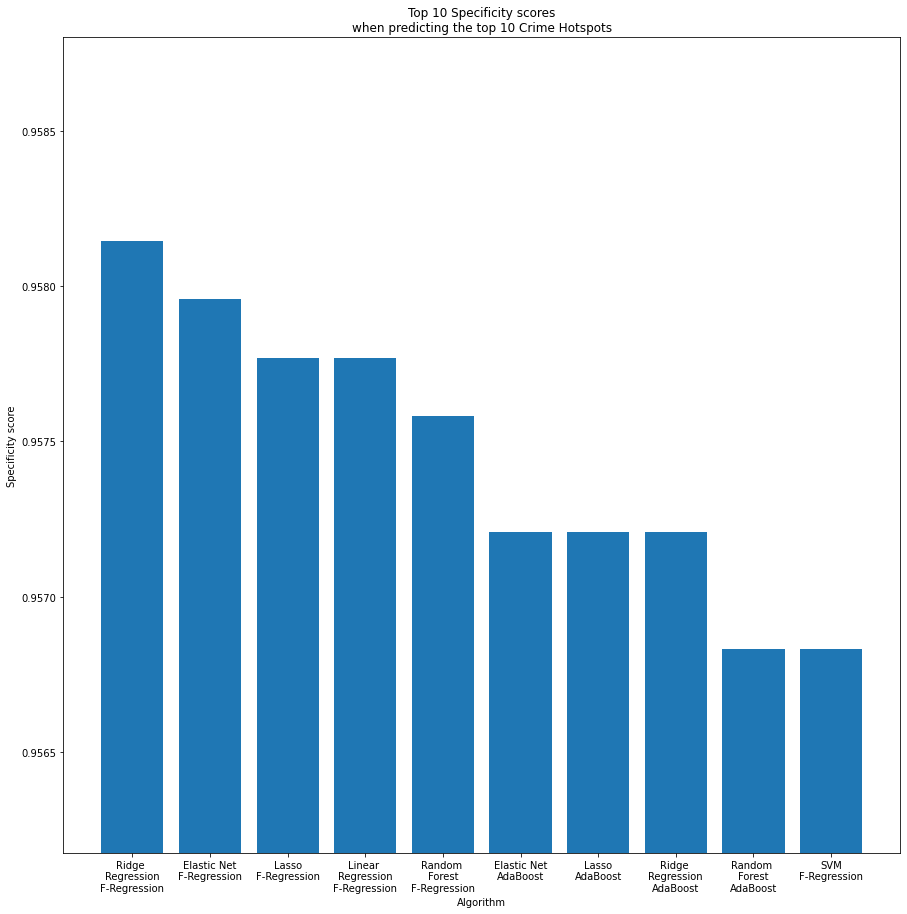

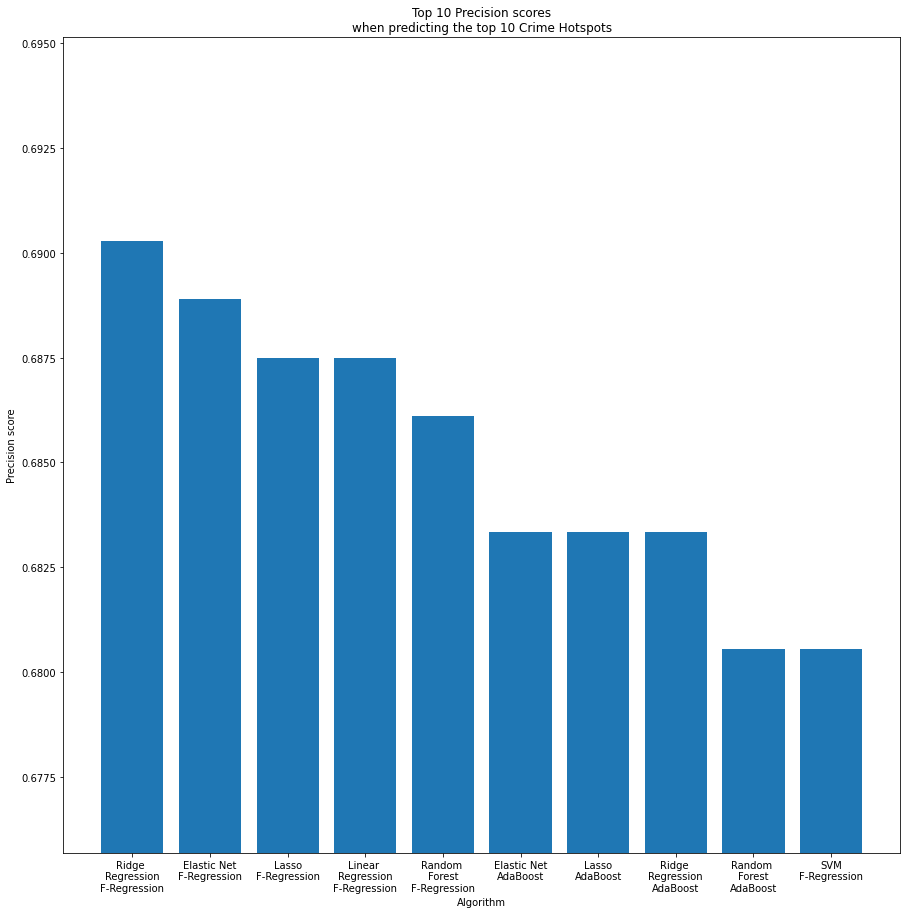

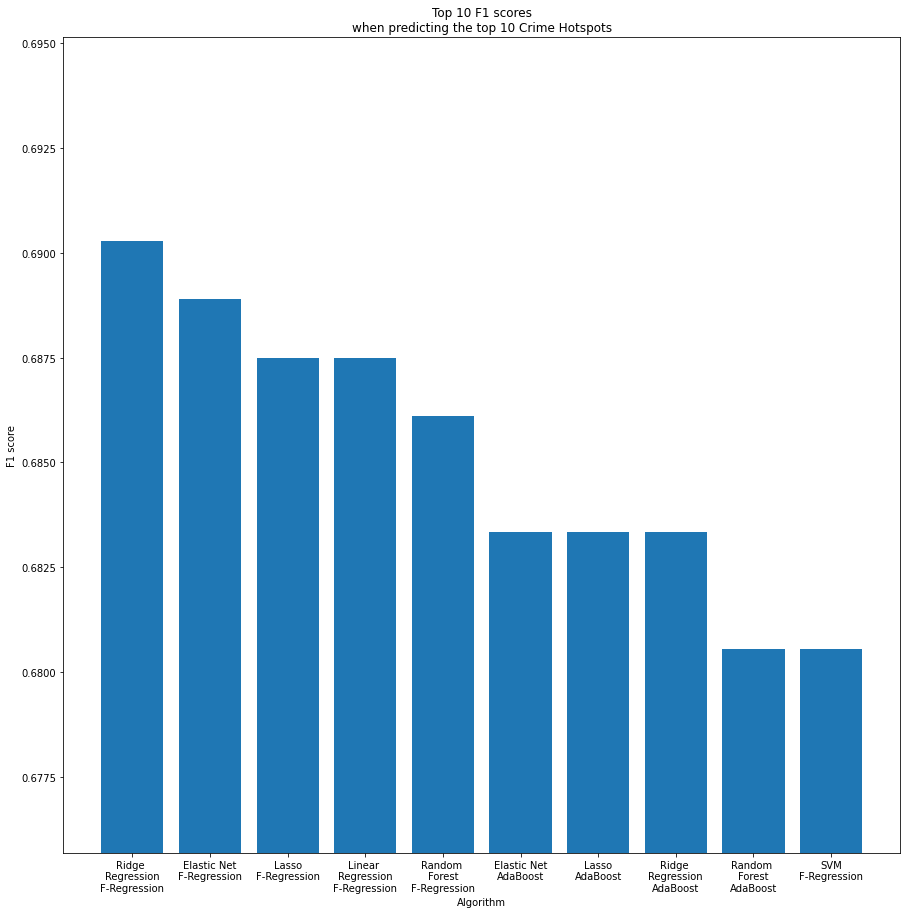

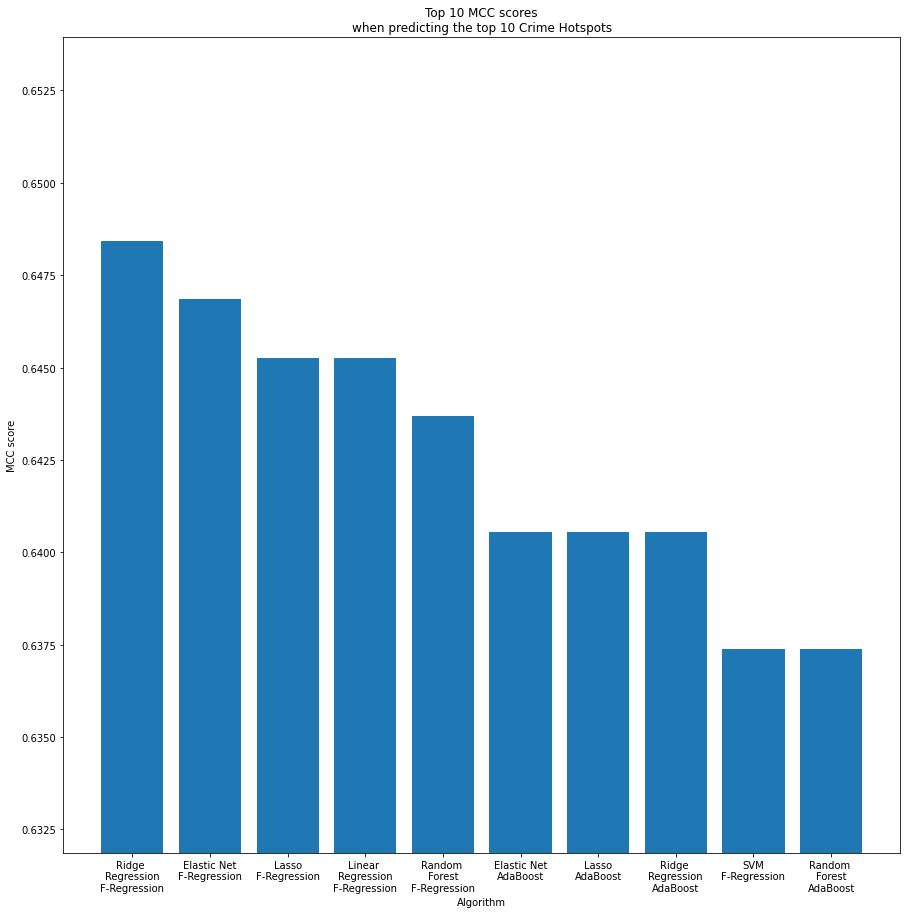

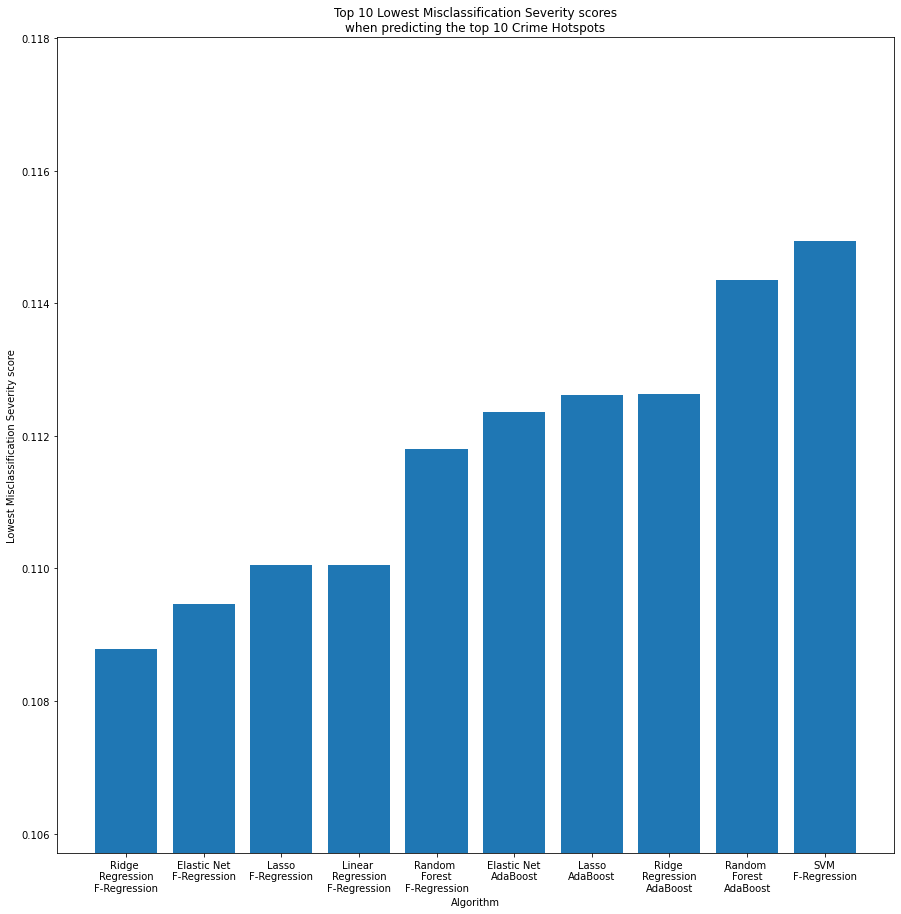

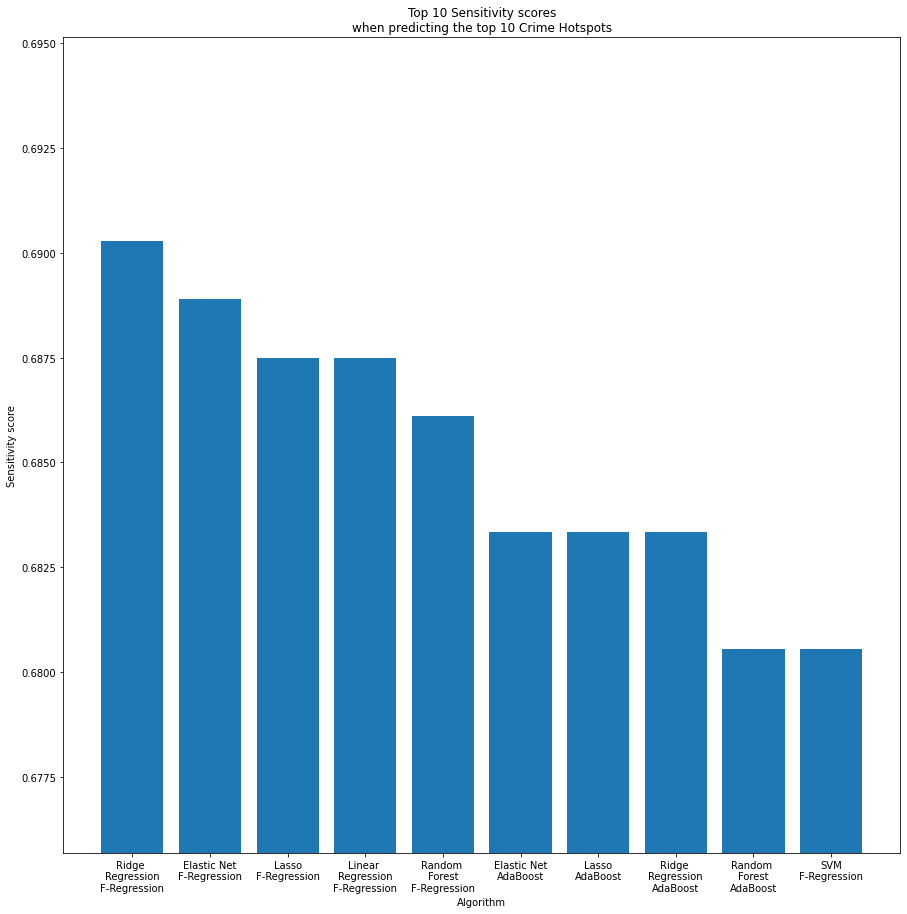

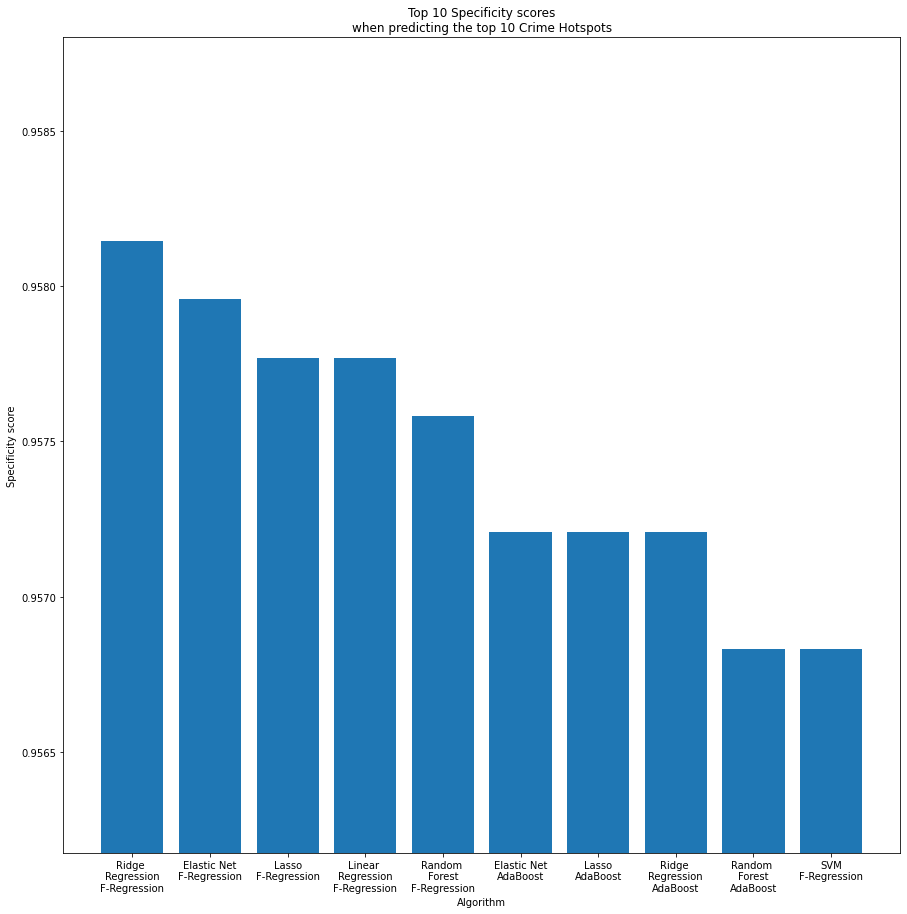

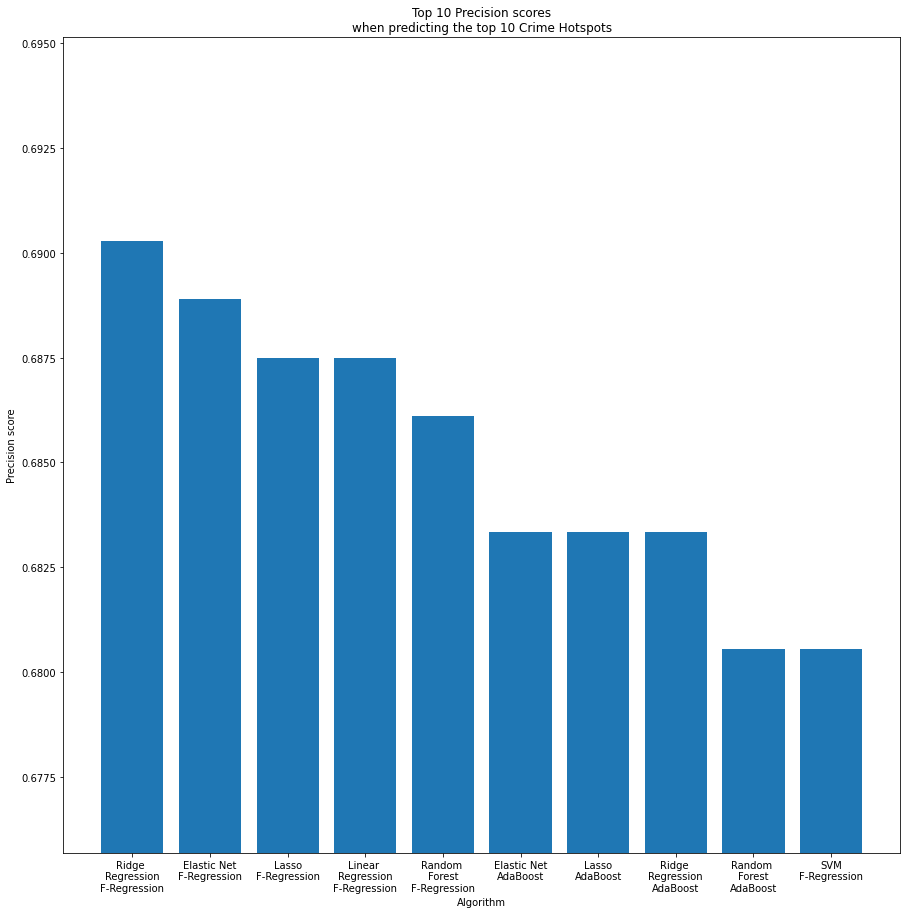

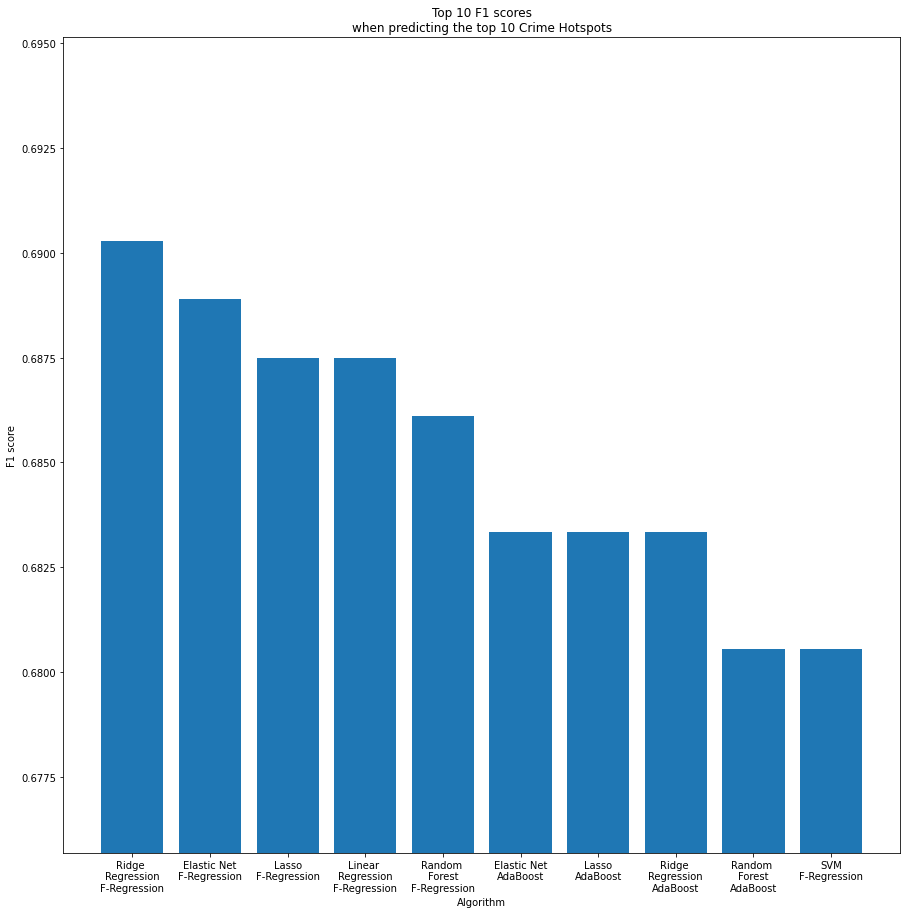

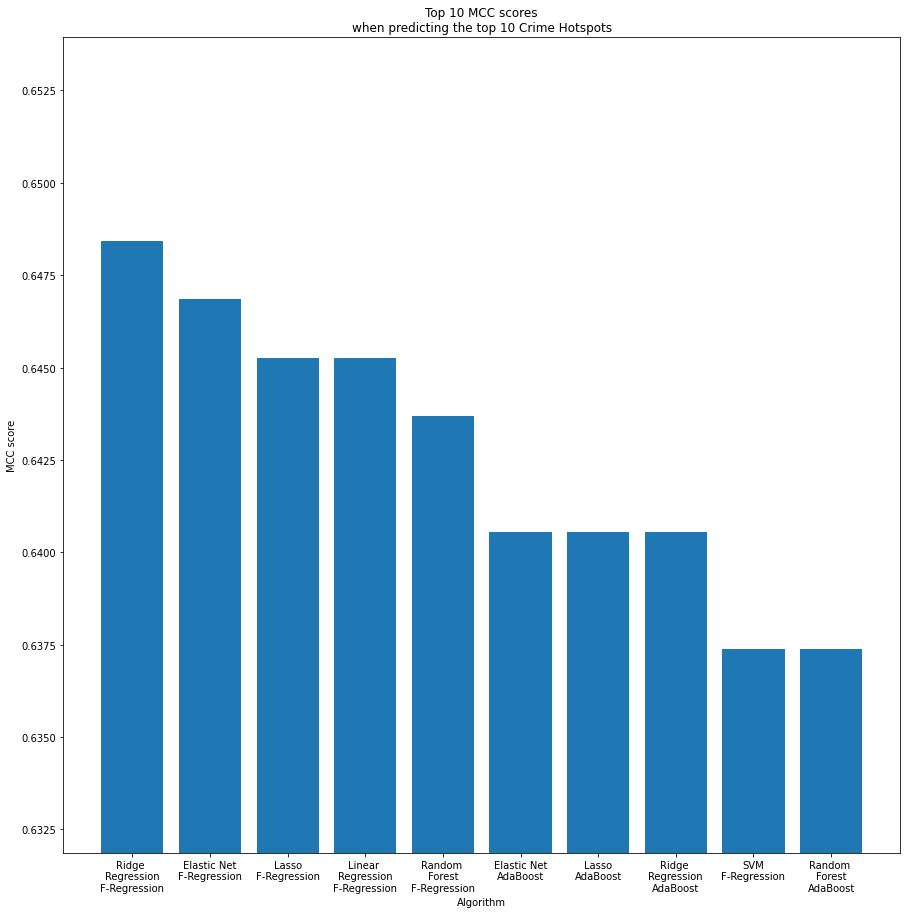

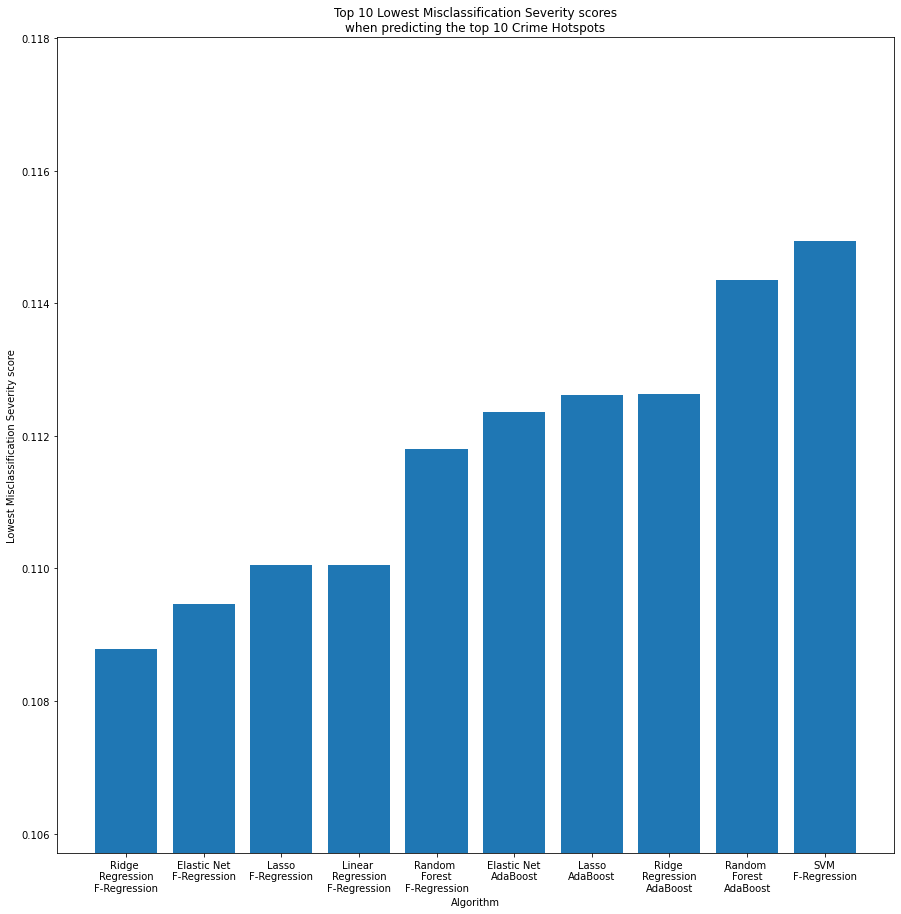

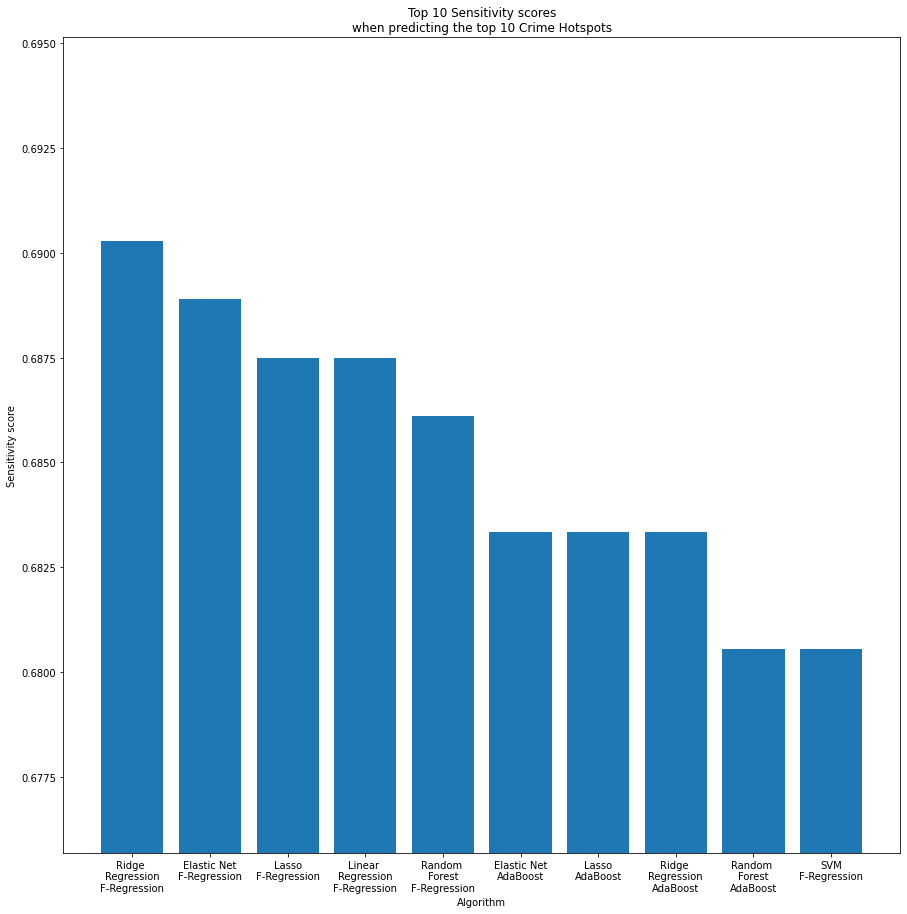

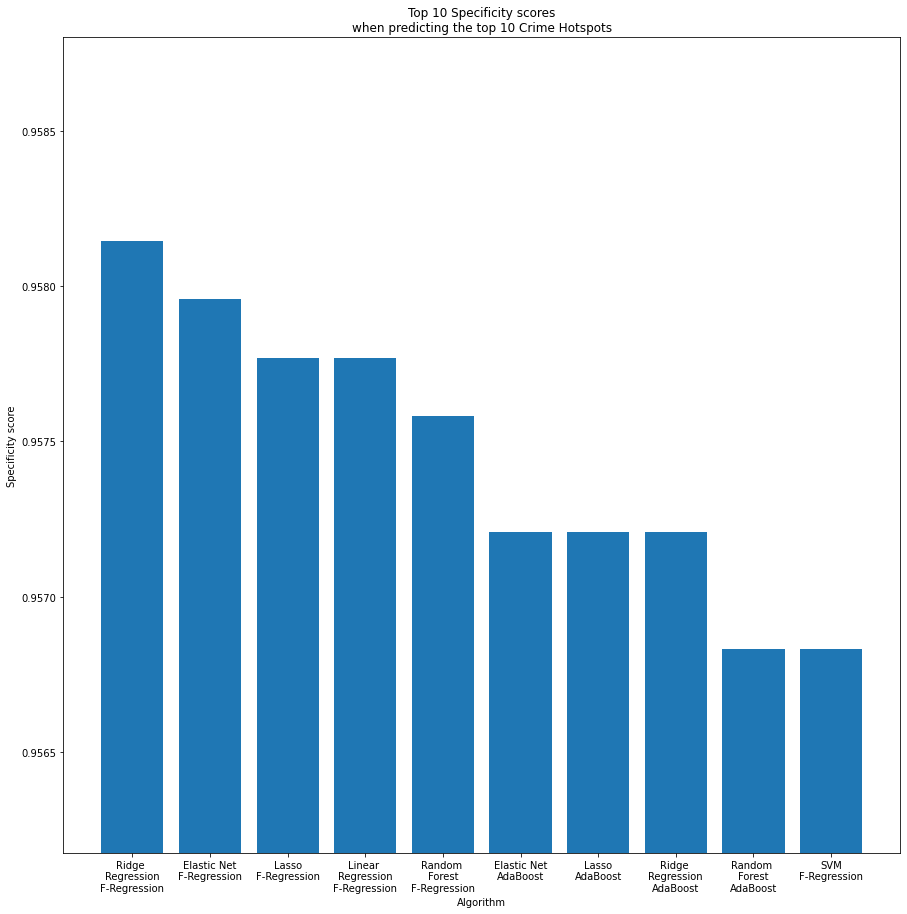

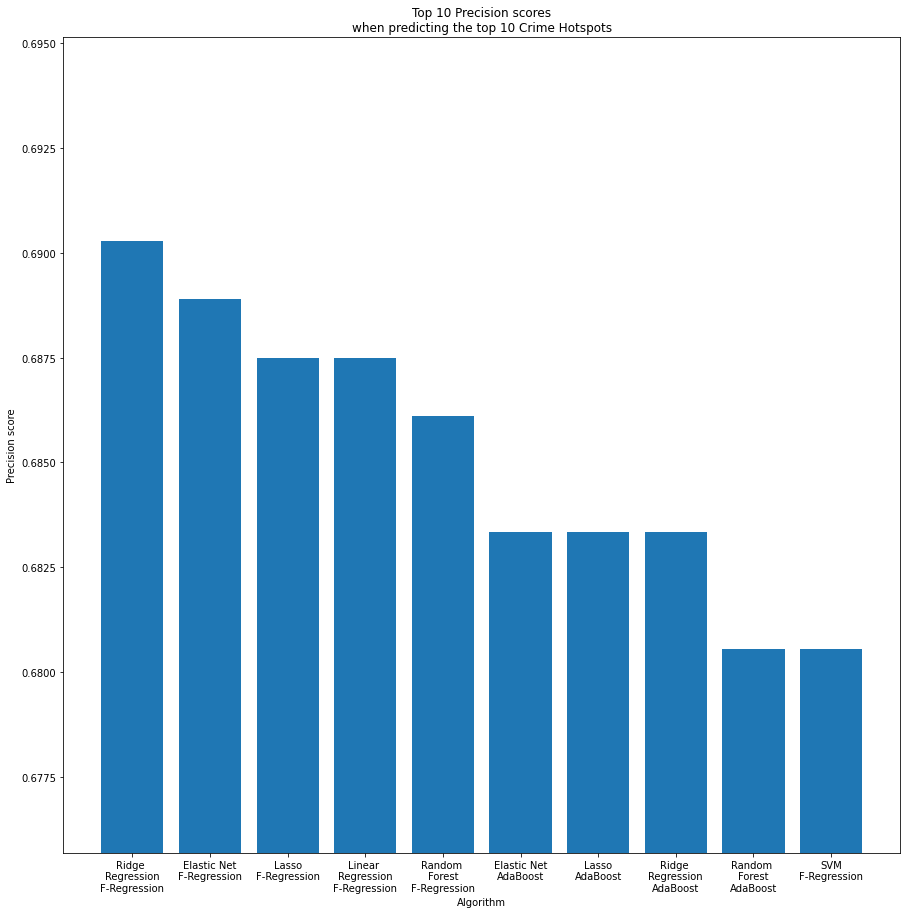

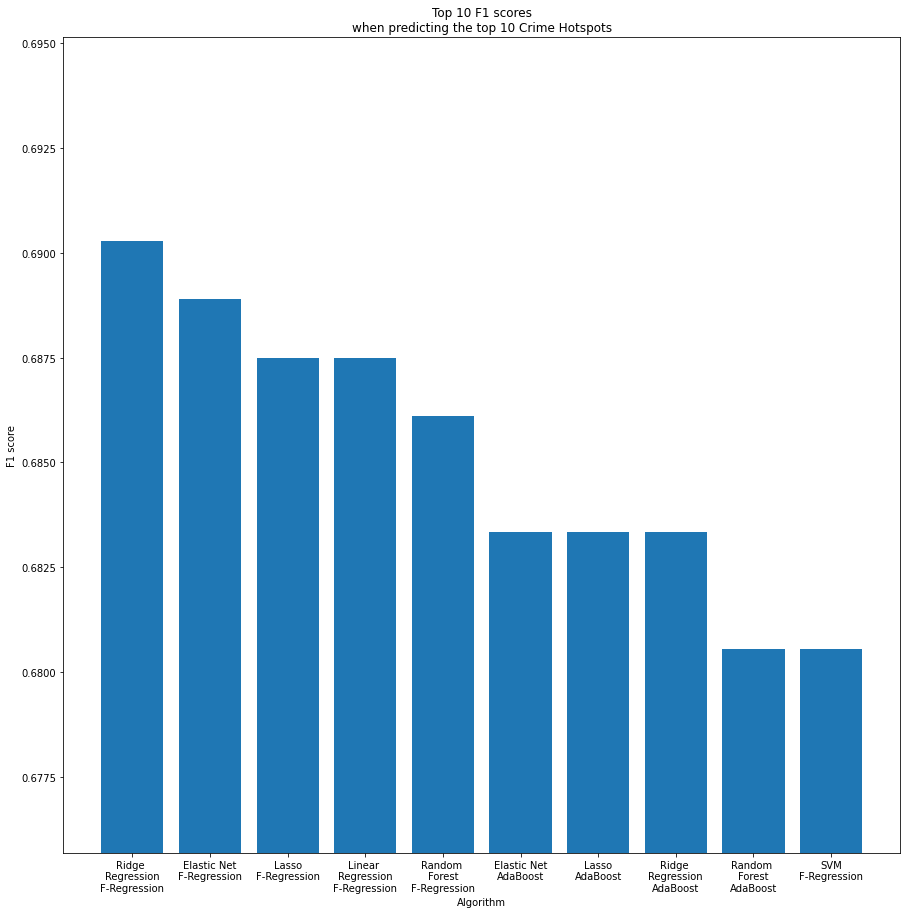

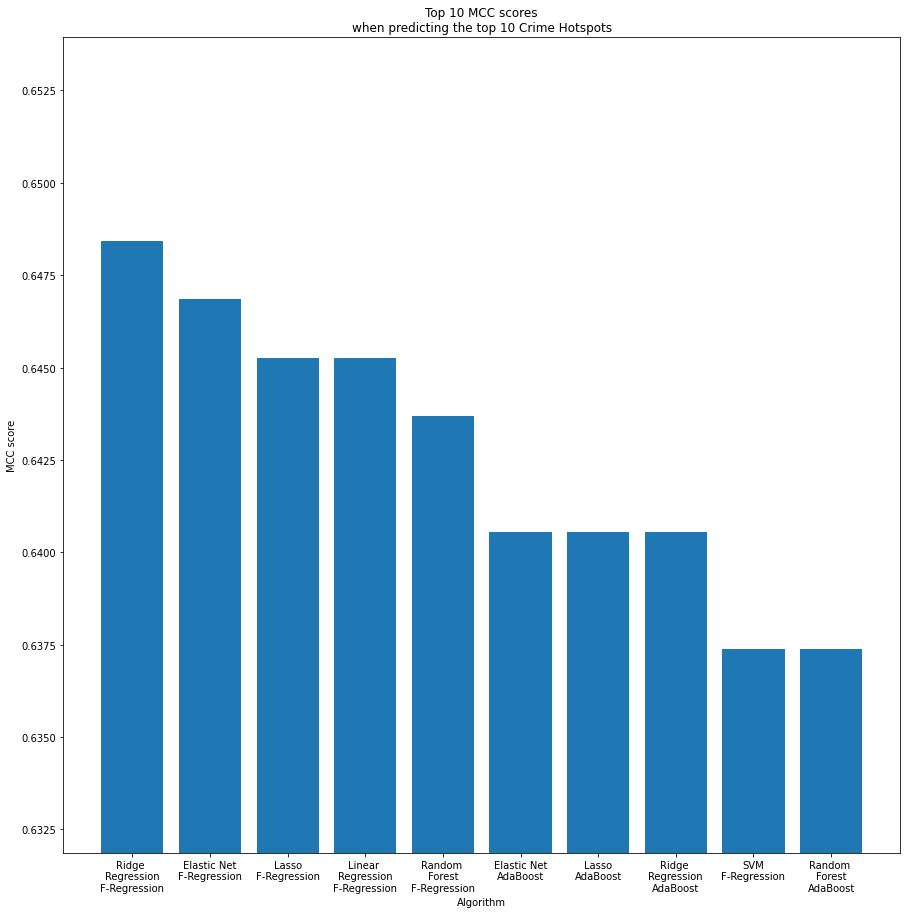

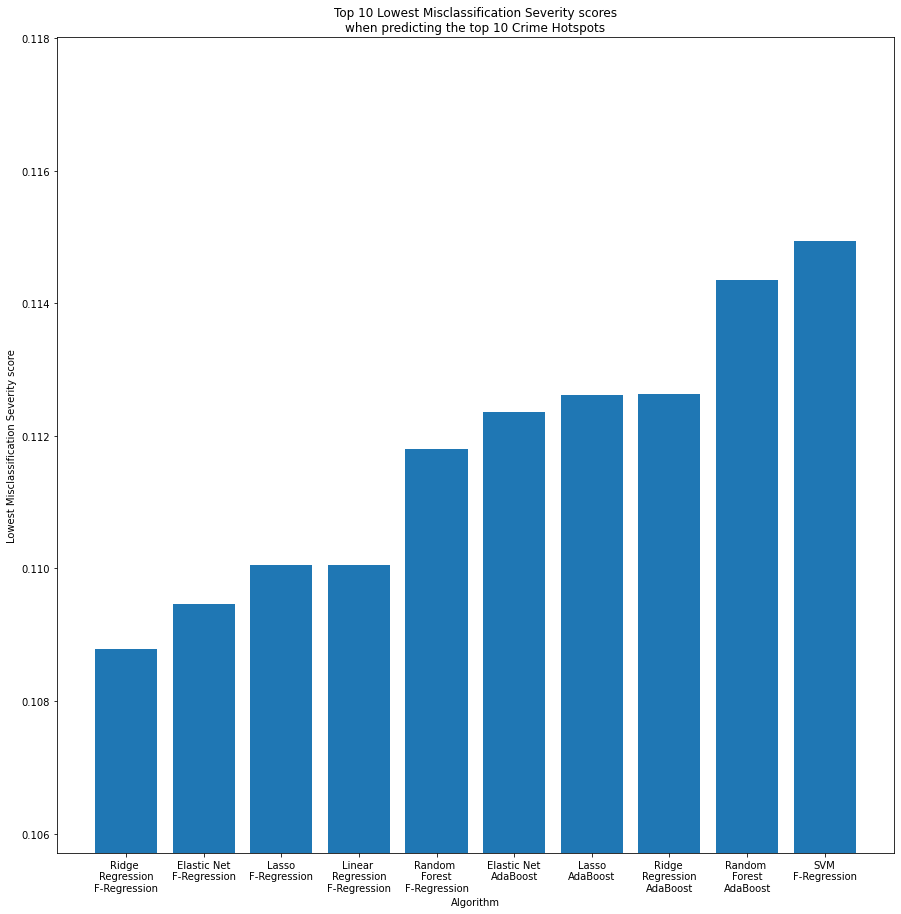

In [96]:
bars = evaluate_models()